In [ ]:
!pip install japanize-matplotlib nptyping &>/dev/null && wait $PID # pyplot用日本語フォント，Numpy用型ヒント
from matplotlib import pylab as plt
import japanize_matplotlib

import numpy as np
import pandas as pd

from pprint import pprint as pprint
from typing import Callable, List, Dict, Any
from nptyping import NDArray, Float

In [ ]:
GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
VARIANTS=["N501Y"]
Matrix=NDArray[(len(GROUPS),len(VARIANTS)),Float[64]]

class PopulationVariable:
    def __init__(self, name, init_values: Matrix,
                target_and_output_funcs: Dict[Any,List[Callable[[Any],Matrix]]]=None,
                init_d_values: Matrix=None,
                output_funcs_self=None) -> None:
        self.name=name
        self.values=[init_values.astype(np.float64)]
        self.target_and_output_funcs=target_and_output_funcs
        self.output_funcs_self=output_funcs_self
        if(init_d_values is not None):
            self.d=[init_d_values.astype(np.float64)]
            #print("__init__: d"+self.name+": init_d_values is not None:",self.d[0])
        else:
            self.d=[np.zeros_like(init_values, dtype=np.float64)]
        self.t=0

    def add_inflow(self, value: Float[64])->None:
        #print(self.name+": add_inflow: self.d["+str(self.t)+"].dtype:",self.d[self.t].dtype)
        #print(self.name+": add_inflow: self.values["+str(self.t)+"].dtype:",self.values[self.t].dtype)
        #print(self.name+": add_inflow: value.dtype:",value.dtype)

        self.d[self.t]=self.d[self.t].astype(np.float64)
        self.values[self.t]=self.values[self.t].astype(np.float64)
        value=value.astype(np.float64)

        self.values[self.t]+=value
        self.d[self.t]+=value
    
    def flush(self):
        # init to next
        self.values.append(np.copy(self.values[self.t]))
        self.d.append(np.zeros_like(self.d[self.t], dtype=np.float))
        self.t+=1
        if( self.target_and_output_funcs is not None):
            out={}
            for target, f in self.target_and_output_funcs.items():
                out[target]=f(self, self.output_funcs_self, self.values[self.t-1])
                

                #print(self.name+"to"+target.name+": self.d["+str(self.t)+"].dtype:",self.d[self.t].dtype)
                #print(self.name+"to"+target.name+": self.values["+str(self.t-1)+"].dtype:",self.values[self.t-1].dtype)
                #print(self.name+"to"+target.name+": self.values["+str(self.t)+"].dtype:",self.values[self.t].dtype)
                #print(self.name+"to"+target.name+": out[target]:",out[target].dtype)

                target.add_inflow(out[target])
                self.values[self.t]-=out[target]
                self.d[self.t]-=out[target]

                #if(self.name is "I"):print(self.t, self.name+"→"+target.name+", out:",out[target])
            #if(self.name is "I"):print(self.t, self.name+"→"+target.name+", sum out:",np.sum(list(out.values())))

            #rint(self.name+"=",self.values[self.t])
            #print(self.name+"d=",self.d[self.t])

            # 負の値が出たときに補正する(そのグループのみ)
            is_negative=(self.values[self.t]<=0)
            if(np.any(is_negative)):
                correction=np.copy(self.values[self.t])
                self.d[self.t][is_negative]=-self.values[self.t][is_negative]
                self.values[self.t][is_negative]=0.0
                correction=correction-self.values[self.t]
                for target, f in self.target_and_output_funcs.items():
                    o=out[target]
                    #print("out補正:",self.t)
                    #print("np.sum(o)=",np.sum(o))
                    #print("np.sum(out.values()[:])=",np.sum(list(out.values())))
                    #print("o=",o)
                    #print("correction=",correction)
                    
                    target.add_inflow(correction*np.sum(o)/np.sum(list(out.values())))
                    #print("分数1:correction*np.sum(o))=",correction*np.sum(o))
                    #print("分数2:np.sum(list(out.values()))=",np.sum(list(out.values())))
                    #print("分数3:correction*np.sum(o)/np.sum(list(out.values()))=",correction*np.sum(o)/np.sum(list(out.values())))
            
            #if(self.name is "V"): print("flush"+self.name,self.values[self.t-1])


In [40]:
class Data:
    def __init__(self,label=None,dV0=None,R0=None):
        self.label=label
        #self.NUM_OF_DAYS=120
        self.NUM_OF_DAYS=365
        self.NUM_OF_CALCULATED_DAYS=0
        self.GROUPS=["0-9","10-19","20-29","30-39","40-40","50-59","60-69","70-79","80-89","90-99","100-"]
        
        self.R0=np.array([[1.9]])
        if(R0 is not None):
            self.R0=R0
        #1.32倍（95％信頼区間1.28-1.37）https://www.niid.go.jp/niid/ja/diseases/ka/corona-virus/2019-ncov/10279-covid19-40.html
        #0.94 (95%信頼区間 0.90-0.97)，1.23 (95%信頼区間 1.18-1.28)

        #https://www.bousai.metro.tokyo.lg.jp/_res/projects/default_project/_page_/001/013/860/47kai/2021052704.pdf
        self.N:Matrix=np.array([[524939+499632], # 0-9
                    [493559+566729], # 10-19
                    [753698+863678], # 20-29
                    [969877+1038390], # 30
                    [1154214+1048170], # 40
                    [891332+722755], # 50
                    [725312+854575], # 60
                    [713342+583971], # 70
                    [449314+261441], # 80
                    [108999+28732], # 90
                    [5142]], dtype=np.float)# >=100
        #ゼロベクトル
        self.ZERO=np.zeros_like(self.N, dtype=np.float)

        self.I0:Matrix=np.array([
                    [8], # 0-19
                    [5], # 0-19
                    [30], # 20-
                    [20], # 30-
                    [17], # 40-
                    [12], # 50-
                    [5], # 60-
                    [3], # 70-
                    [1], # 80-
                    [1], # 90-
                    [0]], dtype=np.float)# >=100
        self.I0=self.I0/np.sum(self.I0)*766.4 #5/7時点陽性者
        # 都道府県名,日付,入院中,軽症・中等症,重症,宿泊療養,自宅療養,調整中
        # 東京都,2021-05-07,2265,2196,69,1152,2157,1271

        self.Q0=np.copy(self.I0)/np.sum(self.I0)*4500 #5/7時点全患者

        # 罹患率10万人あたり https://datastudio.google.com/u/0/reporting/c1dfbd03-0aa7-457d-81d2-3ca5be34706b/page/KNtNB?s=mM99TXFS68A
        # 「同性同世代10万人あたり何人感染しているか。……かかりやすさを比較」
        self.ALPHA=np.array([[413.05+399.74], # 0-9
                        [871.69+749.47], # 10-19
                        [2551.66+2330.63], # 20-29
                        [1821.6+1268.86], # 30
                        [1336.05+842.52], # 40
                        [1249.87+922.23], # 50
                        [945.98+655.33], # 60
                        [748.8+566.84], # 70
                        [952.52+804.37], # 80
                        [1393.54+1336.56], # 90
                        [2597.4+1582.82]], dtype=np.float)# >=100
        self.ALPHA=self.ALPHA/np.sum(self.ALPHA)
        
        #治癒率(I→R，Q→R)
        #self.GAMMA=np.array([[0.178881340543816720383164524]])
        self.GAMMA=np.array([[1.0/10]])# #平均10日目までに排菌が止まる

        #隔離率
        self.EPSILON=self.ZERO+0.151657 #I*(1-EPSILON)^10=0.1*I #完治までに10%が隔離されない
        #self.EPSILON=self.ZERO+1/10 #平均10日で発見・隔離される
        #self.EPSILON=self.ZERO+1/1000

        self.BETA=self.R0*(self.EPSILON+self.GAMMA*self.ALPHA)/2/self.N #BETA=R0*GAMMA/N (R0の定義より．αは年齢別の係数)

        # 重症化率
        self.KAPPA=np.array([
                    [0.5], # <10
                    [0.2], # 10-19
                    [0.3], # 20-29
                    [1], # 30
                    [4], # 40
                    [10], # 50
                    [25], # 60
                    [47], # 70
                    [71], # 80
                    [78], # 90
                    [78]], dtype=np.float)# >=100
        self.KAPPA=self.KAPPA/sum(self.KAPPA)*0.0220672
        #ちなみに大阪5/23-以降の全年齢の重症化率K(t)=dC(t)/I(t-1)=0.06617624
        #重症化しない率(1-p)から: (1-p)^10=0.8⇒p≈0.0220672

        #重症化後退院率．14日で1/1000になる
        self.LAMBDA=np.copy(self.ZERO)+(1-0.5**(1/20)) #(1-LAMBDA)^20=0.5 ⇒ LAMBDA=1-0.5^(1/14)半減期20日のつもり

        # Nに対するワクチン接種割合(速度)[-/day]．Nと同じ形の行列np.array()で年齢別に設定．
        self.OMEGA=np.array([[0], # <10
                    [0], # 10-19
                    [1], # 20-29
                    [1], # 30
                    [1], # 40
                    [1], # 50
                    [1], # 60
                    [1], # 70
                    [1], # 80
                    [1], # 90
                    [1]], dtype=np.float64)# >=100
        self.OMEGA=self.OMEGA*self.N #Nの割合
        if(0<np.sum(self.OMEGA)):
            self.OMEGA=self.OMEGA/np.sum(self.OMEGA)
        self.OMEGA=self.OMEGA*((0.37/100)*np.sum(self.N)) #%/day
        #self.OMEGA=self.OMEGA*(1/100)*np.sum(self.N) #1%/day
        #print("self.OMEGA init=",self.OMEGA)
        
        if(dV0 is not None):
            self.OMEGA=dV0
            #print("dV0 is not None: dV0=",dV0)
        self.dV=[np.copy(self.OMEGA)]

        #print("self.dV init=",self.dV[0])

        def StoV(self, self_orig, s: Matrix)->Matrix:
            #print("t",self.t,"←",self.t-1)
            self_orig.dV.append(self_orig.dV[self.t-1])

            #Sがマイナスになりそうな世代のdV[-1]を0に．傾きを維持する
            is_neg_vec=(s-self_orig.dV[self.t]<0)
            if(np.any(is_neg_vec)):
                self_orig.dV[self.t][is_neg_vec]=s[is_neg_vec]
                if(0<np.sum(self_orig.dV[self.t])):
                    #print("分数:self_orig.dV[self.t]/np.sum(self_orig.dV[self.t])*np.sum(self_orig.dV[0])",self_orig.dV[self.t]/np.sum(self_orig.dV[self.t])*np.sum(self_orig.dV[0]))
                    self_orig.dV[self.t]=self_orig.dV[self.t]/np.sum(self_orig.dV[self.t])*np.sum(self_orig.dV[0])
            if(False and self.t<10):
                print("t",self.t)
                print("np.sum(s)=",self.t,np.sum(s))
                print("np.sum(v)=",self.t,np.sum(self_orig.V.values[self.t-1]))
                print("np.sum(dv)=",self.t,np.sum(self_orig.dV[self.t]))
                print("dv=",self.t,self_orig.dV[self.t])
            return np.copy(self_orig.dV[self.t])

        def StoI(self, self_orig, s: Matrix)->Matrix:
            self_orig.positives.append(self_orig.BETA*self_orig.I.values[-1]*s)
            return self_orig.BETA*np.sum(self_orig.I.values[-1])*s

        def ItoR(self, self_orig, i: Matrix)->Matrix:
            return self_orig.GAMMA*i
        
        def ItoC(self, self_orig, i: Matrix)->Matrix:
            return self_orig.KAPPA*i

        def ItoQ(self, self_orig, i: Matrix)->Matrix:
            return self_orig.EPSILON*i
        
        def CtoR(self, self_orig, c: Matrix)->Matrix:
            return self_orig.LAMBDA*c

        def QtoC(self, self_orig, q: Matrix)->Matrix:
            return self_orig.KAPPA*q

        def QtoR(self, self_orig, q: Matrix)->Matrix:
            return self_orig.GAMMA*q

        self.positives=[np.copy(self.ZERO)] #newly quarantined

        self.V=PopulationVariable('V',np.copy(self.ZERO), {}, init_d_values=self.dV[0]) #→出口なし
        self.R=PopulationVariable('R',np.copy(self.ZERO), {}) #→出口なし
        self.C=PopulationVariable('C',np.copy(self.ZERO), {self.R:CtoR},output_funcs_self=self) #critical(severe)
        self.Q=PopulationVariable('Q',np.copy(self.Q0), {self.C:QtoC,self.R:QtoR}, output_funcs_self=self) #quarantined
        self.I=PopulationVariable('I',477.2*self.ALPHA,{self.R:ItoR,self.C:ItoC,self.Q:ItoQ},output_funcs_self=self)
        self.S=PopulationVariable('S',np.copy(self.N),{self.I:StoI,self.V:StoV},output_funcs_self=self)
        self.pipeline=[self.S,self.I,self.Q,self.C,self.R,self.V]
        
        print("label",self.label)
        #print("N=",self.N)
        print("np.sum(N)=",np.sum(self.N))
        print("γ=",self.GAMMA)
        print("np.sum(γ)=",np.sum(self.GAMMA))
        print("ε=",self.EPSILON)
        
        #print("α=",self.ALPHA)
        print("sum(α)=",np.sum(self.ALPHA))

        self.BETA=self.R0*(self.EPSILON+self.ALPHA*self.GAMMA)/self.N
        print("β=(ε+αγ)R0*N=",self.BETA*self.N)
        print("sum(β)=",np.sum(self.BETA*self.N))

        print("κ=",self.KAPPA)
        print("(大阪5/23-以降の重症化率K(t)=C(t)/I(t-1)=0.6617624)\nsum(κ)/len(κ)=",np.sum(self.KAPPA)/len(self.KAPPA))

        print("dV=",self.V.d)
        print("sum(dV[0])=",sum(self.V.d))
        print("validation sum(self.V.d)/sum(N)=1=",np.sum(self.V.d)/np.sum(self.N))

    def calc(self):
        for t in range(self.NUM_OF_DAYS):
            for pvar in self.pipeline:
                pvar.flush()
            self.NUM_OF_CALCULATED_DAYS=t
        return self

data0=Data(label="0.37%/day接種,R0=1.5",R0=1.5).calc()
data1=Data(label="0.37%/day接種,R0=1.32",R0=1.32).calc()

data2=Data(label="接種なし,R0=1.5",R0=1.5,
    dV0=np.array([[0], # <10
    [0], # 10-19
    [0], # 20-29
    [0], # 30
    [0], # 40
    [0], # 50
    [0], # 60
    [0], # 70
    [0], # 80
    [0], # 90
    [0]]),# >=100
    ).calc()

data3=Data(label="接種なし,R0=1.32",R0=1.32,
    dV0=np.array([[0], # <10
    [0], # 10-19
    [0], # 20-29
    [0], # 30
    [0], # 40
    [0], # 50
    [0], # 60
    [0], # 70
    [0], # 80
    [0], # 90
    [0]]),# >=100
    ).calc()

datas=[data0,data1,data2,data3]

label 0.37%/day接種,R0=1.5
np.sum(N)= 13257801.0
γ= [[0.1]]
np.sum(γ)= 0.1
ε= [[0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]]
sum(α)= 1.0
β=(ε+αγ)R0*N= [[0.23211388]
 [0.23671708]
 [0.25528736]
 [0.24508391]
 [0.23989121]
 [0.23985437]
 [0.23660405]
 [0.23497732]
 [0.23748999]
 [0.24303186]
 [0.25128947]]
sum(β)= 2.6523404999999998
κ= [[3.50273016e-05]
 [1.40109206e-05]
 [2.10163810e-05]
 [7.00546032e-05]
 [2.80218413e-04]
 [7.00546032e-04]
 [1.75136508e-03]
 [3.29256635e-03]
 [4.97387683e-03]
 [5.46425905e-03]
 [5.46425905e-03]]
(大阪5/23-以降の重症化率K(t)=C(t)/I(t-1)=0.6617624)
sum(κ)/len(κ)= 0.002006109090909091
dV= [array([[   0.        ],
       [   0.        ],
       [7100.95352286],
       [8817.12763668],
       [9669.38202589],
       [7086.51344453],
       [6936.36121618],
       [5695.74379588],
       [3120.51014801],
       [ 604.69639073],
       [  22.57551925]])]
sum(dV[0])= [[   0.        ]
 [

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide


label 接種なし,R0=1.32
np.sum(N)= 13257801.0
γ= [[0.1]]
np.sum(γ)= 0.1
ε= [[0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]
 [0.151657]]
sum(α)= 1.0
β=(ε+αγ)R0*N= [[0.20426021]
 [0.20831103]
 [0.22465288]
 [0.21567384]
 [0.21110427]
 [0.21107185]
 [0.20821156]
 [0.20678004]
 [0.20899119]
 [0.21386804]
 [0.22113473]]
sum(β)= 2.33405964
κ= [[3.50273016e-05]
 [1.40109206e-05]
 [2.10163810e-05]
 [7.00546032e-05]
 [2.80218413e-04]
 [7.00546032e-04]
 [1.75136508e-03]
 [3.29256635e-03]
 [4.97387683e-03]
 [5.46425905e-03]
 [5.46425905e-03]]
(大阪5/23-以降の重症化率K(t)=C(t)/I(t-1)=0.6617624)
sum(κ)/len(κ)= 0.002006109090909091
dV= [array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])]
sum(dV[0])= [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
validation sum(self.V.d)/sum(N)=1= 0.0


0.37%/day接種,R0=1.32


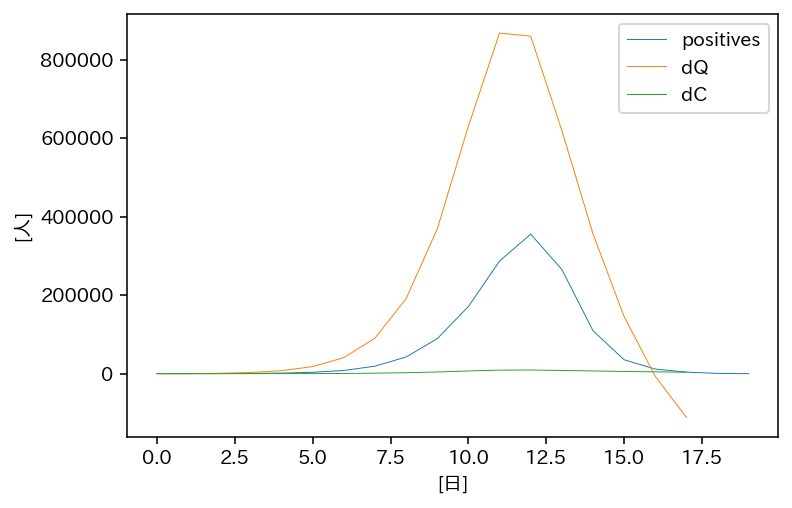

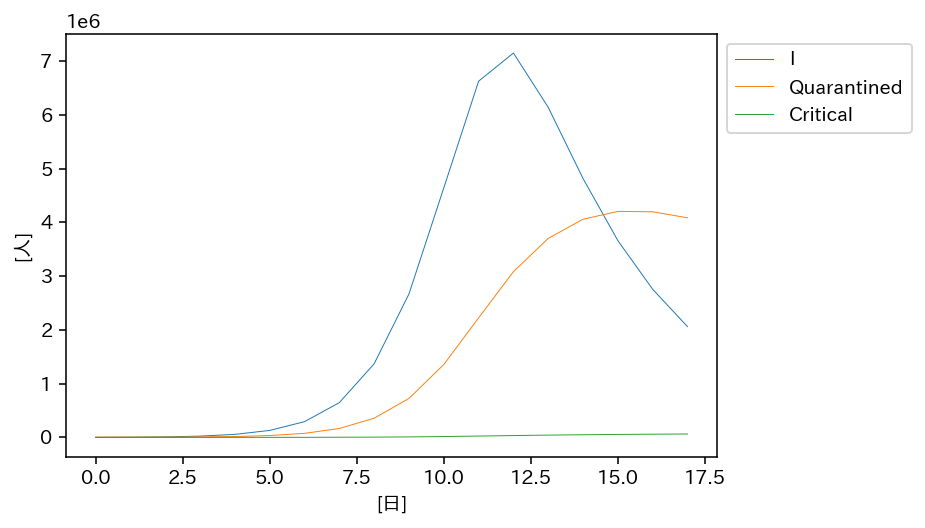

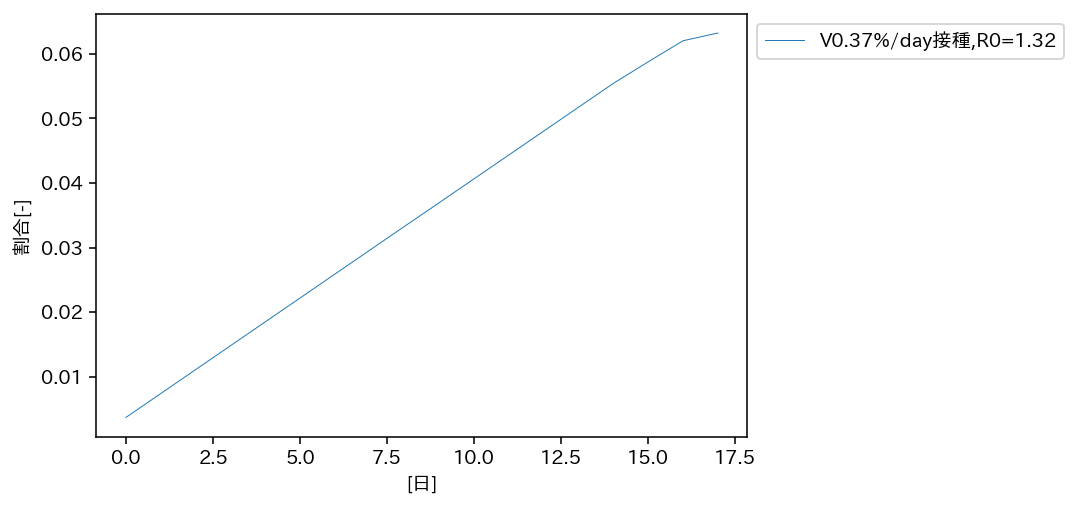

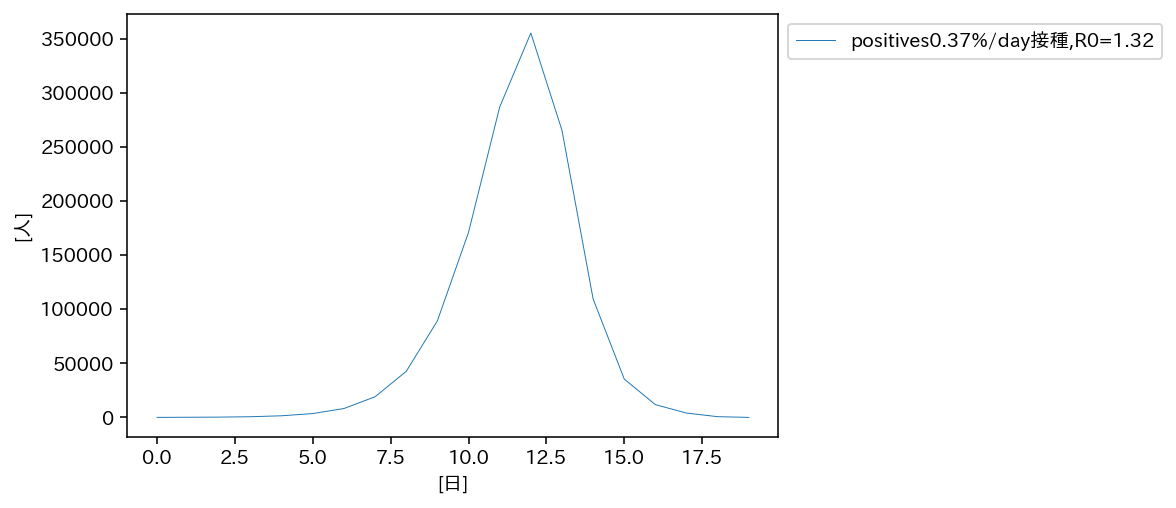

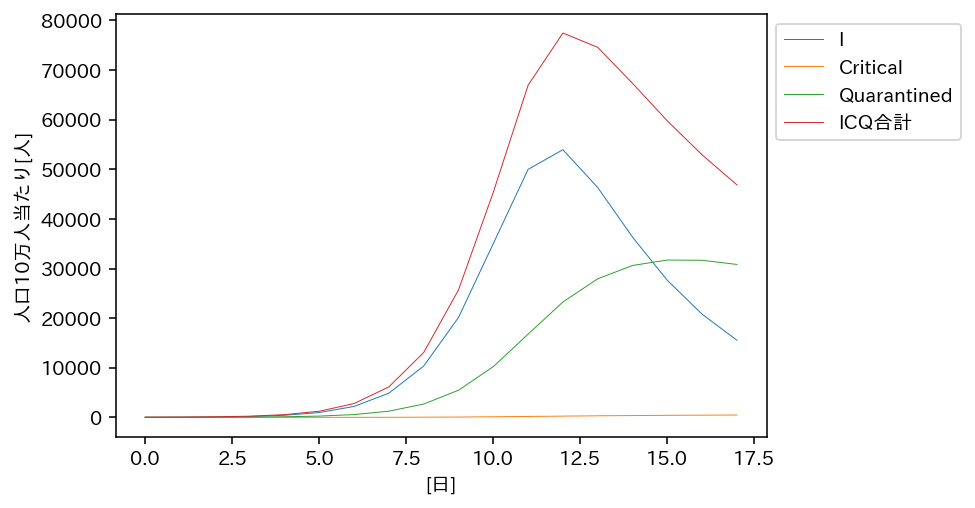

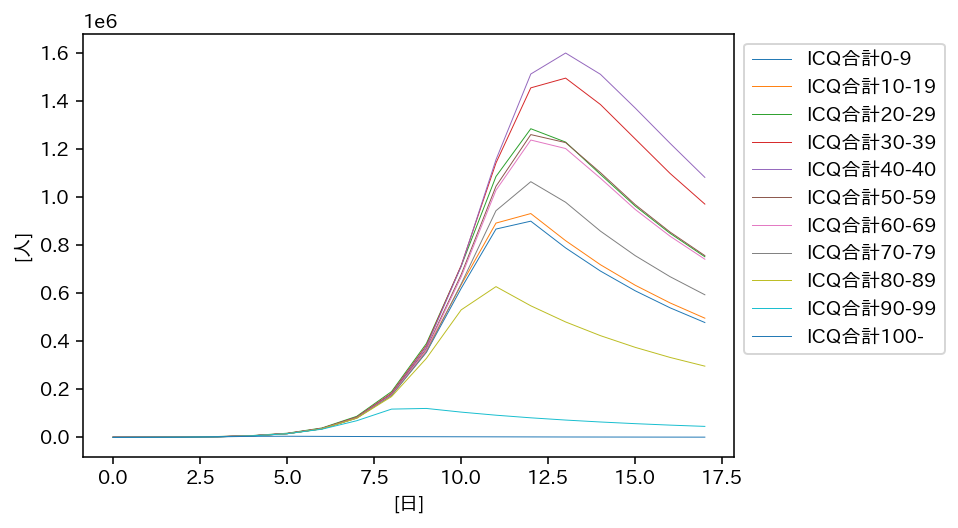

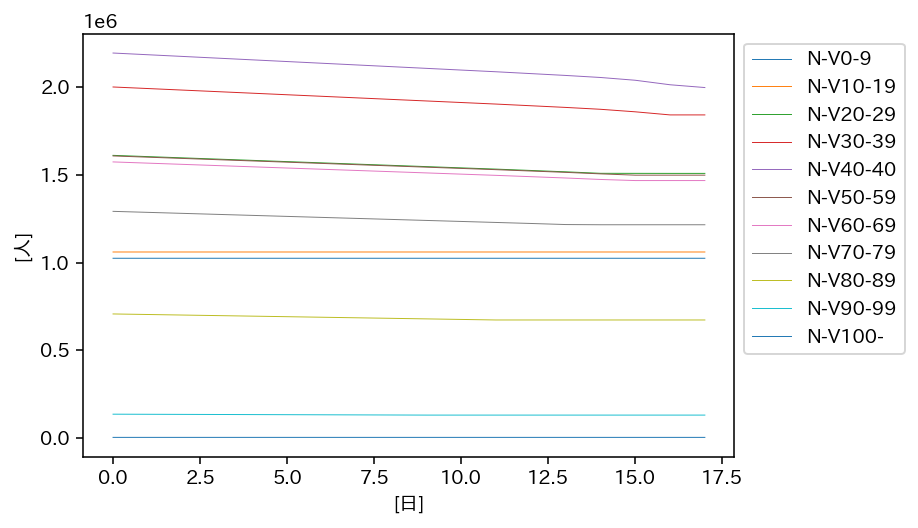

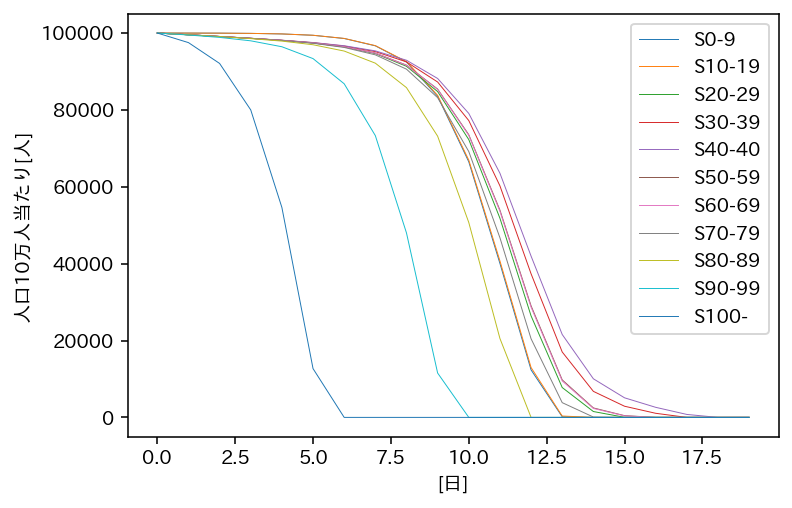

接種なし,R0=1.5


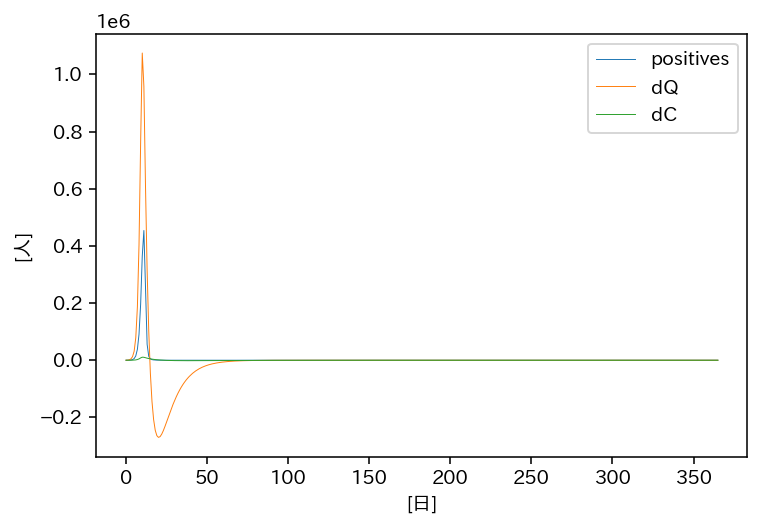

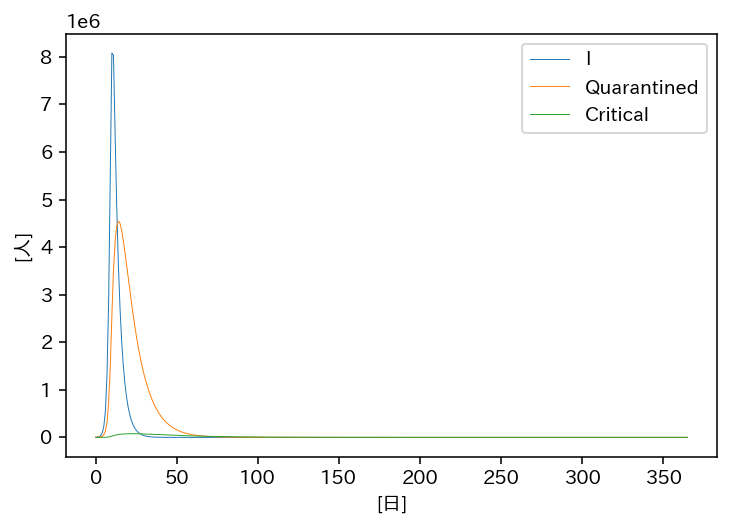

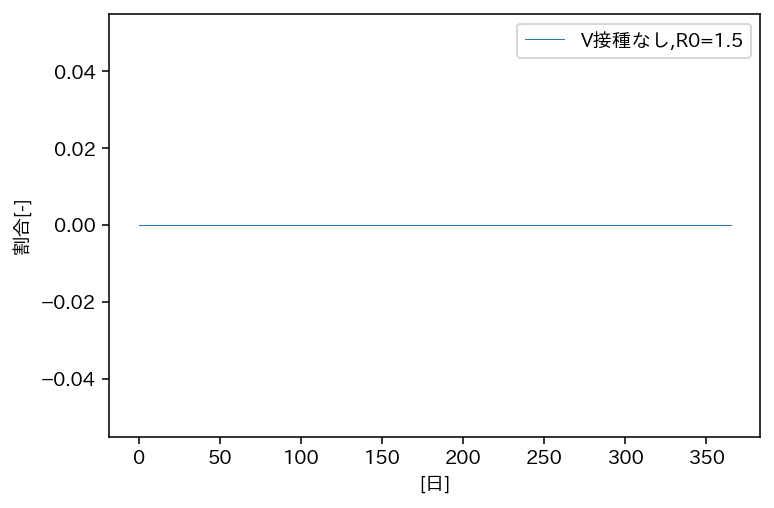

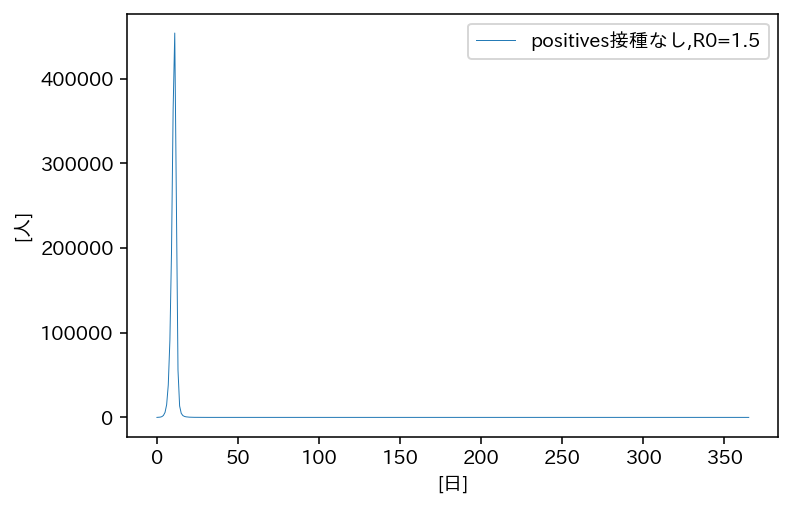

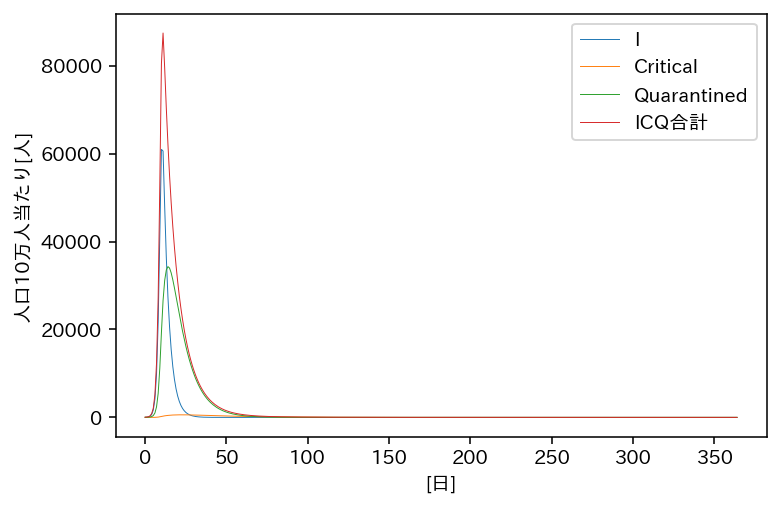

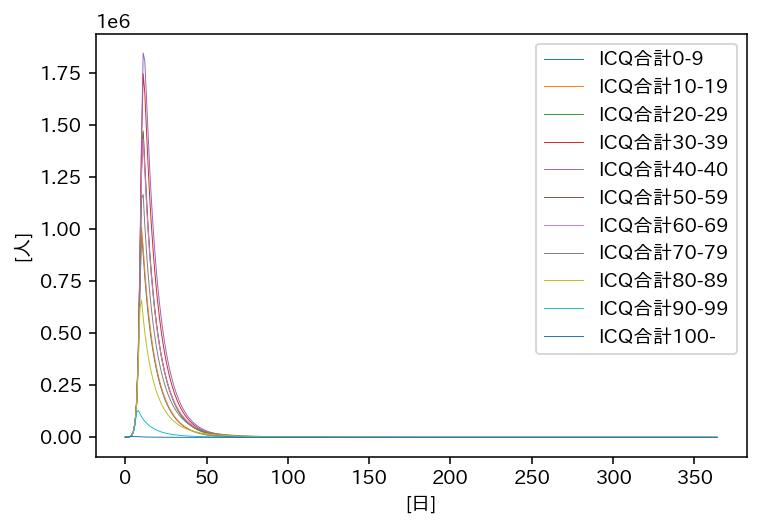

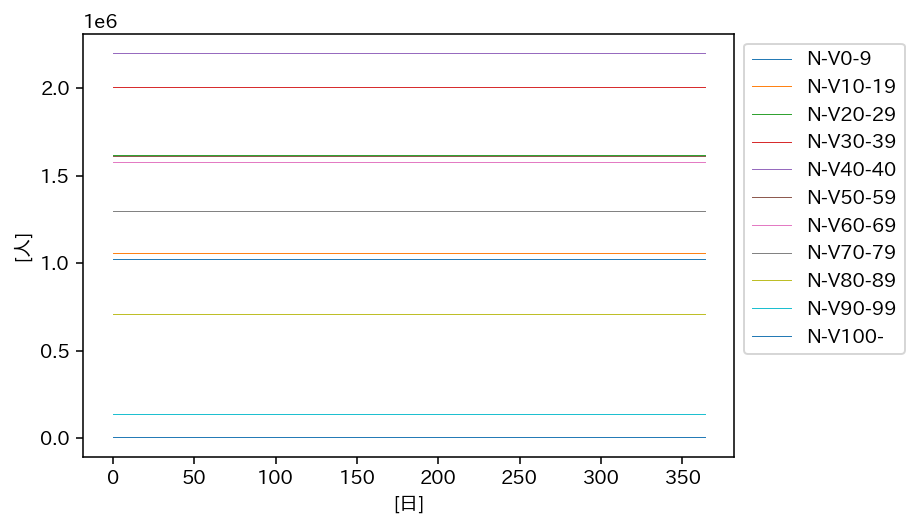

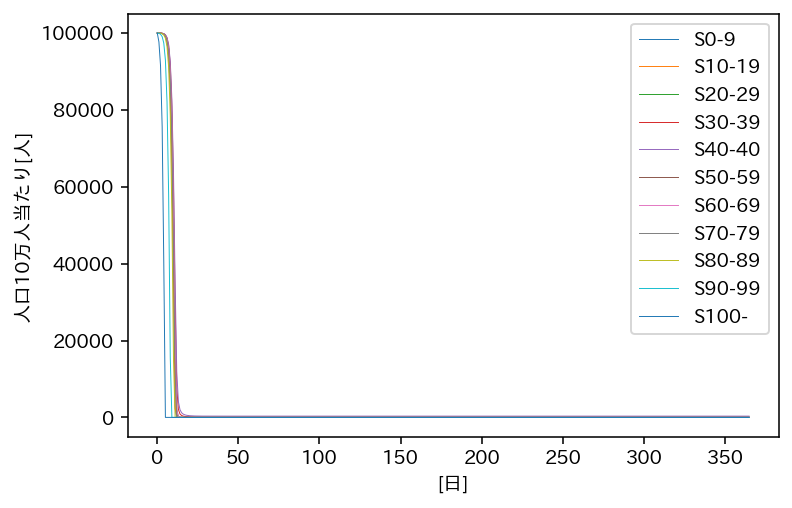

In [41]:
# plot
plt.rcParams["figure.dpi"]=140
def plot(d):
    N=d.N
    S=d.S.values
    I=d.I.values
    R=d.R.values
    Q=d.Q.values
    C=d.C.values
    V=d.V.values
    positives=d.positives

    dS=d.S.d
    dI=d.I.d
    dR=d.R.d
    dQ=d.Q.d
    dC=d.C.d
    dV=d.V.d
    #print("S",S[0].shape)
    T=range(0,d.NUM_OF_CALCULATED_DAYS+1)
    #print("NUM_OF_DAYS:",d.NUM_OF_DAYS)
    #print("NUM_OF_CALCULATED_DAYS:",d.NUM_OF_CALCULATED_DAYS)
    #print("len(S)",len(S))
    #print("len(I)",len(I))
    #print("len(R)",len(R))
    #print("len(Q)",len(Q))
    #print("len(C)",len(C))
    #print("len(V)",len(V))
    #print("len(dV)",len(dV))
    #print("sum(S[-1])",sum(S[-1]))
    #print("sum(I[-1])",sum(I[-1]))
    #print("sum(R[-1])",sum(R[-1]))
    #print("sum(Q[-1])",sum(Q[-1]))
    #print("sum(C[-1])",sum(C[-1]))
    #print("sum(V[-1])",sum(V[-1]))
    #print("sum(dV[-1])",sum(dV[-1]))

    #plt.plot([np.sum(m) for m in S], label="S", linewidth=.5)
    #plt.plot([np.sum(m) for m in dS], label="dS", linewidth=.5)
    #plt.plot([np.sum(m) for m in dI], label="dI", linewidth=.5)
    plt.plot([np.sum(m) for m in positives], label="positives", linewidth=.5)
    #plt.plot([np.sum(m) for m in dR], label="dR", linewidth=.5)
    plt.plot([np.sum(m) for m in dQ], label="dQ", linewidth=.5)
    plt.plot([np.sum(m) for m in dC], label="dC", linewidth=.5)
    #plt.plot([np.sum(m) for m in dV], label="dV", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #plt.plot([np.sum(m) for m in S], label="S", linewidth=.5)
    plt.plot([np.sum(m) for m in I], label="I", linewidth=.5)
    plt.plot([np.sum(m) for m in Q], label="Quarantined", linewidth=.5)
    plt.plot([np.sum(m) for m in C], label="Critical", linewidth=.5)
    #plt.plot([np.sum(R[t])+sum(V[t]) for t in T], label="RV", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #print("V",V)
    plt.plot([np.sum(v) for v in V]/np.sum(N), label="V"+d.label, linewidth=.5)
    #plt.plot([np.sum(dv) for dv in dV], label="dV"+d.label, linewidth=.5)
    #plt.plot([(sum(I[t])+sum(C[t])+sum(Q[t]))/sum(N)*100000for t in T], label="ICQ合計", linewidth=.5)
    #plt.plot([(sum(S[t])+sum(I[t])+sum(Q[t])+sum(C[t])+sum(R[t])+sum(V[t]))/sum(N)*100000for t in T], label="SIQCRV=N", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("割合[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.plot([np.sum(v) for v in positives], label="positives"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    plt.plot([np.sum(I[t])/sum(N)*100000 for t in T], label="I", linewidth=.5)
    plt.plot([np.sum(C[t])/sum(N)*100000 for t in T], label="Critical", linewidth=.5)
    #plt.plot([np.sum(positives[t])/sum(N)*100000for t in T], label="positives/day", linewidth=.5)
    plt.plot([np.sum(Q[t])/sum(N)*100000 for t in T], label="Quarantined", linewidth=.5)
    plt.plot([(sum(I[t])+sum(Q[t])+sum(C[t]))/sum(N)*100000for t in T], label="ICQ合計", linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("人口10万人当たり[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    #plt.yscale('log')
    for k, age in enumerate(GROUPS):
        #plt.plot([I[t][k] for t in T], label="I"+age, linewidth=.5)
        #plt.plot([C[t][k] for t in T], label="Critical"+age, linewidth=.5)
        #plt.plot([Q[t][k] for t in T], label="Quarantined"+age, linewidth=.5)
        plt.plot([(I[t][k]+C[t][k]+Q[t][k]) for t in T], label="ICQ合計"+age, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for k, age in enumerate(GROUPS):
        plt.plot([N[k]-V[t][k] for t in T], label="N-V"+str(age), linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for k, age in enumerate(GROUPS):
        plt.plot([s[k][0]/N[k]*100000 for s in S], label="S"+str(age), linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("人口10万人当たり[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()


print(data1.label)
plot(data1)
print(data2.label)
plot(data2)


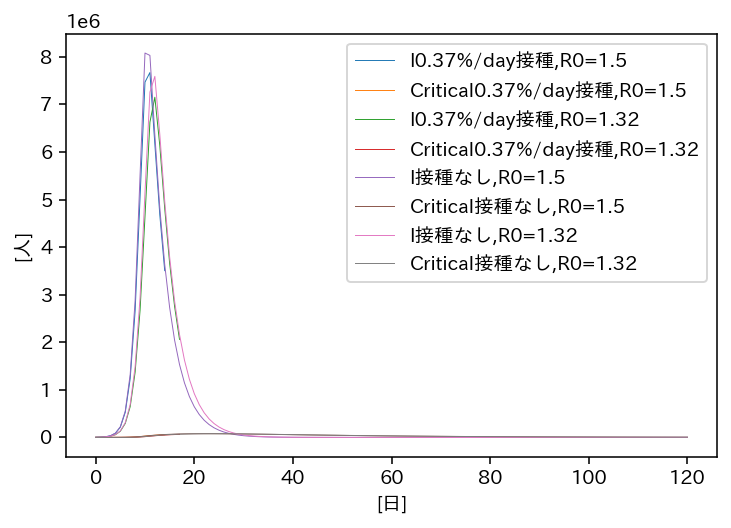

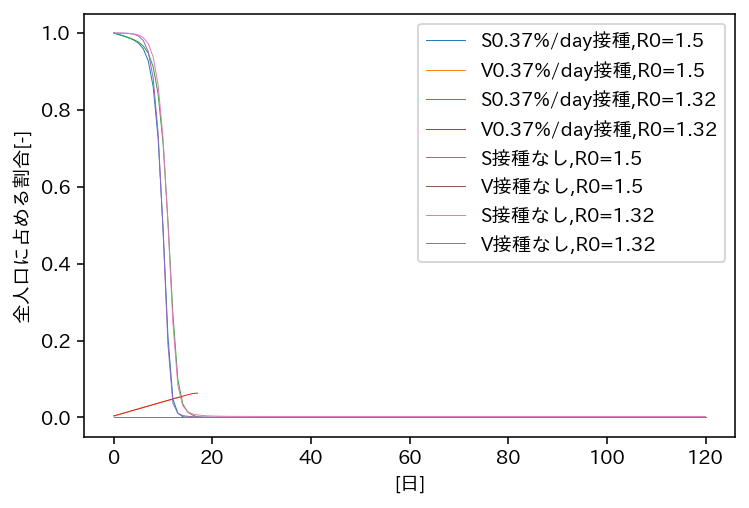

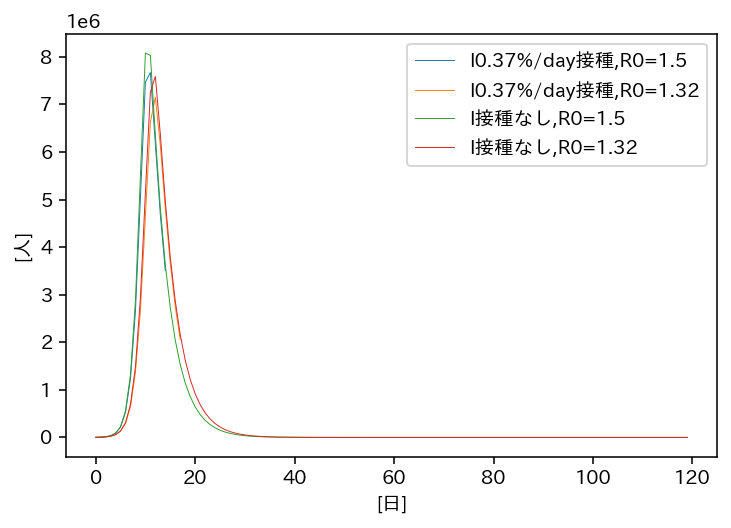

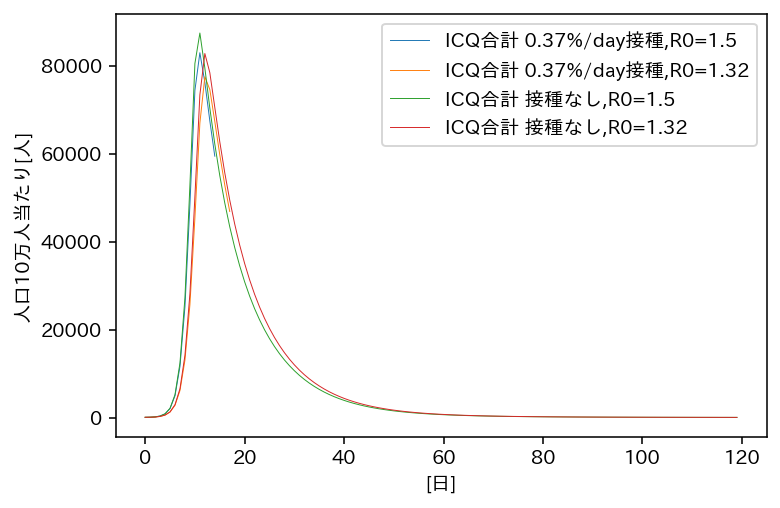

In [38]:
# two data plot
def plotdiff(datas):
    class Localdata:
        pass
    ds=[]
    for i, d in enumerate(datas):
        ds.append(Localdata())
        ds[i].S=d.S.values
        ds[i].I=d.I.values
        ds[i].R=d.R.values
        ds[i].Q=d.Q.values
        ds[i].C=d.C.values
        ds[i].V=d.V.values
        ds[i].dV=d.V.d
        ds[i].dI=d.I.d
        ds[i].dC=d.C.d
        ds[i].N=d.N
        ds[i].NUM_OF_CALCULATED_DAYS=d.NUM_OF_CALCULATED_DAYS
        ds[i].NUM_OF_DAYS=d.NUM_OF_DAYS
        ds[i].label=d.label


    T=range(0,ds[-1].NUM_OF_CALCULATED_DAYS+1)
    #print("NUM_OF_DAYS:",ds[-1].NUM_OF_DAYS)
    #print("NUM_OF_CALCULATED_DAYS:",ds[-1].NUM_OF_CALCULATED_DAYS)
    #print("len(S)",len(ds[0].S))

    for i, d in enumerate(ds):
        plt.plot([np.sum(i) for i in d.I], label="I"+d.label, linewidth=.5)
        plt.plot([np.sum(c) for c in d.C], label="Critical"+d.label, linewidth=.5)
        #plt.plot([np.sum(di) for di in d.dI], label="dI"+d.label, linewidth=.5)
        #plt.plot([np.sum(dc) for dc in d.dC], label="dC"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([np.sum(s) for s in d.S]/sum(d.N), label="S"+d.label, linewidth=.5)
        plt.plot([np.sum(v) for v in d.V]/sum(d.N), label="V"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.I], label="I"+d.label, linewidth=.5)
        #plt.plot([np.sum(v) for v in d.C], label="Critical"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.C[t])+sum(d.I[t]) for t in T], label="I+C"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.C[t])+sum(d.Q[t])+sum(d.V[t]) for t in T], label="SIRCQV"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("全人口に占める割合[-]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        plt.plot([np.sum(d.I[t]) for t in T], label="I"+d.label, linewidth=.5)
        #plt.plot([np.sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.C[t])+sum(d.Q[t])+sum(d.V[t]) for t in T], label="SIRCQV"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()

    for i, d in enumerate(ds):
        #plt.plot([np.sum(v)/sum(d.N)*100000for v in d.V], label="V"+d.label, linewidth=.5)
        plt.plot([(sum(d.I[t])+sum(d.C[t])+sum(d.Q[t]))/sum(d.N)*100000 for t in T], label="ICQ合計 "+d.label, linewidth=.5)
        #plt.plot([(sum(d.S[t])+sum(d.I[t])+sum(d.Q[t])+sum(d.C[t])+sum(d.R[t])+sum(d.V[t]))/sum(d.N)*100000for t in T], label="SIQCRV=N", linewidth=.5)
        #plt.plot([(np.sum(d.S[t])+sum(d.I[t])+sum(d.R[t])+sum(d.C[t])+sum(d.Q[t])+sum(d.V[t]))/sum(d.N)*100000 for t in T], label="SIRCQV"+d.label, linewidth=.5)
    plt.xlabel("[日]")
    plt.ylabel("人口10万人当たり[人]")
    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
plotdiff(datas)
